*It's a method used to determine customer value by looking at three dimensions:*

- **Recency**: When is the last time the user takes an action? 
- **Frequency**: How many times does the user take this action?
- **Monetary**: What is the sum of monetary value from this user throughout his/her lifetime?

- *Recency : the interval between the **last action** and **today***
- *Frequency : the number of action between the user's **signup date** and **today***
- *Monetary : the sum of revenue within the user's lifetime*

### Library

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px


In [2]:
df = pd.read_csv("C:/Users/emirh/OneDrive/Belgeler/GitHub/CRM/RFM_analysis/online_retail_listing.csv",delimiter=";",encoding="unicode_escape")

In [3]:
def check_df(df):
    print("---------------- Shape ----------------")
    print(df.shape)
    print("---------------- Columns ----------------")
    print(df.columns)
    print("---------------- Types ----------------")
    print(df.dtypes)
    print("---------------- Head ----------------")
    print(df.head())
    print("---------------- Tail ----------------")
    print(df.tail())
    print("---------------- Describe ----------------")
    print(df.describe().T)

check_df(df)    

---------------- Shape ----------------
(1048575, 8)
---------------- Columns ----------------
Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')
---------------- Types ----------------
Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price           object
Customer ID    float64
Country         object
dtype: object
---------------- Head ----------------
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

       InvoiceDate Price  Customer ID         Country  
0  1.12.2009 

In [4]:
df["Price"] = df["Price"].str.replace(",",".").astype("float64")

In [5]:
df.Price.max()

38970.0

In [6]:
df["Total_Price"] = df["Quantity"] * df["Price"]
df["Total_Price"].head()

0     83.4
1     81.0
2     81.0
3    100.8
4     30.0
Name: Total_Price, dtype: float64

### Top 5 Most Ordered Product

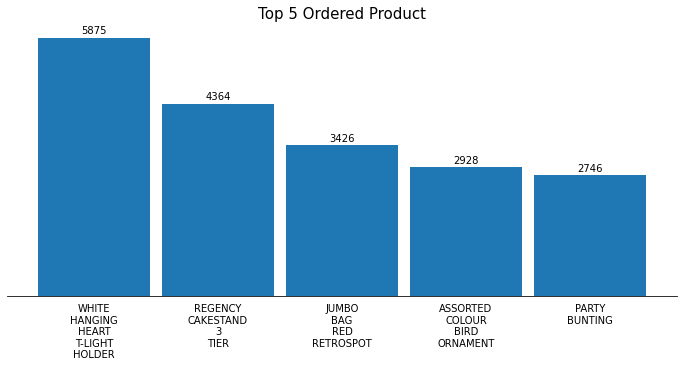

In [7]:
fig, ax = plt.subplots(figsize=(12,5))

counts = (df
          .Description
          .value_counts()
          .head()
          )


(counts
.plot.bar(width=.9, rot=0, ax=ax)
)

ax.set_xticklabels(["\n".join(label.split()) for label in counts.index])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

ax.set_title("Top 5 Ordered Product",fontsize=15)

ax.get_yaxis().set_visible(False)
ax.tick_params(bottom=False)
for pos, value in enumerate(counts):
    ax.text(pos, value+100, f"{value}",ha="center")

### Top 5 Expensive Product

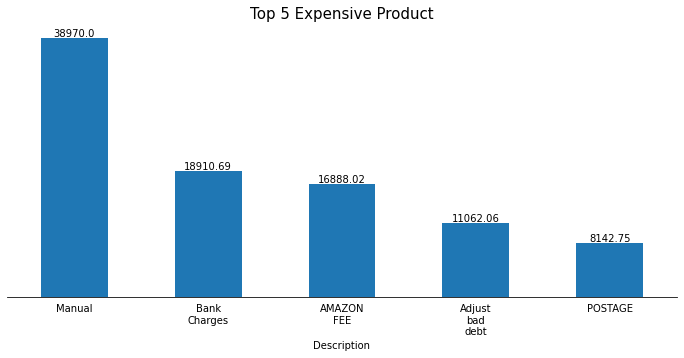

In [8]:
fig, ax = plt.subplots(figsize=(12,5))
max_desc =(df
.groupby("Description")
.Price
.max()
.sort_values(ascending=False)
.head()
)
(
max_desc
.plot(kind="bar",rot=0, ax=ax)
)
ax.set_xticklabels(["\n".join(label.split()) for label in max_desc.index])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.set_title("Top 5 Expensive Product",fontsize=15)

ax.get_yaxis().set_visible(False)
ax.tick_params(bottom=False)
for pos, value in enumerate(max_desc):
    ax.text(pos, value+200, f"{value}",ha="center")

### How many orders came from which country?

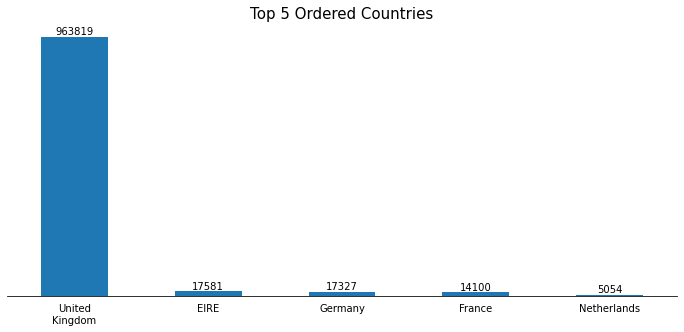

In [9]:
fig ,ax = plt.subplots(figsize=(12,5))
c_counts=(df
.Country
.value_counts()
.head()
)
(
c_counts
.plot(kind="bar",rot=0,ax=ax)
)
ax.set_xticklabels(["\n".join(label.split()) for label in c_counts.index])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

ax.set_title("Top 5 Ordered Countries",fontsize=15)
ax.get_yaxis().set_visible(False)
ax.tick_params(bottom=False)
for pos, value in enumerate(c_counts):
    ax.text(pos, value+10000, f"{value}",ha="center")

### The invoice with the most expensive purchase

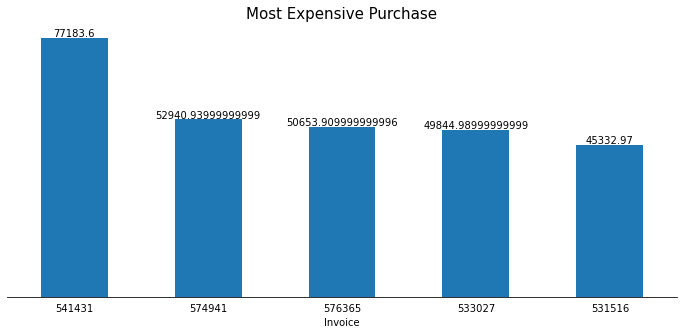

In [10]:
fig, ax = plt.subplots(figsize=(12,5))

i_counts=(df
.groupby("Invoice")
.Total_Price
.sum()
.sort_values(ascending=False)
.head()
)
(
i_counts
.plot(kind="bar",rot=0,ax=ax)
)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

ax.set_title("Most Expensive Purchase",fontsize=15)
ax.get_yaxis().set_visible(False)
ax.tick_params(bottom=False)
for pos, value in enumerate(i_counts):
    ax.text(pos, value+200, f"{value}",ha="center")



## Missing data analysis

In [11]:
(df
.isna()
.mean()
.mul(100))

Invoice         0.000000
StockCode       0.000000
Description     0.416947
Quantity        0.000000
InvoiceDate     0.000000
Price           0.000000
Customer ID    22.571776
Country         0.000000
Total_Price     0.000000
dtype: float64

In [12]:
df.dropna(inplace=True)

In [13]:
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
Total_Price    0
dtype: int64

## Outlier Engineering

<AxesSubplot:>

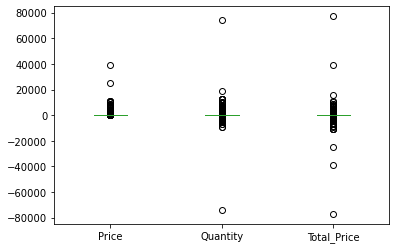

In [14]:
df[["Price","Quantity","Total_Price"]].plot(kind="box")


In [15]:
def outlier(data,col):
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    lower = data[col].quantile(0.25) - (IQR * 1.5)
    upper  = data[col].quantile(0.75) + (IQR * 1.5)
    b_total = df[(df[col] > upper) | (df[col] < lower)].shape[0]
    print(f"Total Outliers of the {col} : {b_total}")
    df[col] = np.where(df[col]<lower,lower,np.where(df[col]>upper,upper,data[col]))
    a_total = df[(df[col] > upper) | (df[col] < lower)].shape[0]
    print(f"(After Replacement) Total Outliers of the {col} : {a_total}")

In [16]:
for col in ["Quantity","Price","Total_Price"]:
    outlier(df,col)

Total Outliers of the Quantity : 53226
(After Replacement) Total Outliers of the Quantity : 0
Total Outliers of the Price : 70281
(After Replacement) Total Outliers of the Price : 0
Total Outliers of the Total_Price : 68158
(After Replacement) Total Outliers of the Total_Price : 0


### How many unique items in the dataset?

In [17]:
df["Description"].nunique()

5297

### Remove the canceled transactions from the dataset


In [18]:
df = df[~df["Invoice"].str.contains("C", na=False)]

### Drop duplicate

In [19]:
df.drop_duplicates(subset=["Invoice", "Customer ID"], keep="first", inplace=True)


## Calculating of RFM metrics

In [20]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["InvoiceDate"].max() # last purchase '9.12.2010 20:01'
today_date = dt.datetime(2012,1,1)


In [21]:
rfm = df.groupby("Customer ID").agg(
    {"InvoiceDate" : lambda date: (today_date - date.max()).days,
    "Invoice" : lambda num: num.nunique(),
    "Total_Price": lambda  TotalPrice: TotalPrice.sum()}
)

rfm.columns=["Recency","Frequency","Monetary"]
rfm = rfm[rfm["Monetary"] > 0]

In [22]:
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,5860.0,233.064334,213.833055,21.000,51.0,142.000,401.0000,1083.00
Frequency,5860.0,6.221843,12.863268,1.000,1.0,3.000,7.0000,391.00
Monetary,5860.0,132.762236,337.088736,0.001,20.4,52.575,127.2175,9562.18


In [23]:
rfm["R_Score"] = pd.qcut(rfm["Recency"],5,labels=[5,4,3,2,1])
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"),5, labels=[1,2,3,4,5])
rfm["M_Score"] = pd.qcut(rfm["Monetary"],5,labels=[1,2,3,4,5])
rfm["RFM_Score"] = rfm["R_Score"].astype(str) + rfm["F_Score"].astype(str) + rfm["M_Score"].astype(str)
rfm.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
Customer ID,,,,,,,
12346.0,347,12,253.990,2,5,5,255
12347.0,61,7,160.835,4,4,5,445
12348.0,97,5,179.310,3,4,5,345
12349.0,40,4,95.025,5,3,4,534
12350.0,332,1,25.200,2,1,2,212


In [24]:
seg_map = {r'[1-2][1-2]': 'hibernating',
           r'[1-2][3-4]': 'at_Risk',
           r'[1-2]5': 'cant_loose',
           r'3[1-2]': 'about_to_sleep',
           r'33': 'need_attention',
           r'[3-4][4-5]': 'loyal_customers',
           r'41': 'promising',
           r'51': 'new_customers',
           r'[4-5][2-3]': 'potential_loyalists',
           r'5[4-5]': 'champions'}

rfm["Segment"] = rfm["R_Score"].astype(str) + rfm["F_Score"].astype(str)
rfm["Segment"] = rfm["Segment"].replace(seg_map, regex=True)
rfm.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
Customer ID,,,,,,,,
12346.0,347,12,253.990,2,5,5,255,cant_loose
12347.0,61,7,160.835,4,4,5,445,loyal_customers
12348.0,97,5,179.310,3,4,5,345,loyal_customers
12349.0,40,4,95.025,5,3,4,534,potential_loyalists
12350.0,332,1,25.200,2,1,2,212,hibernating


### Who are the top 10 of our best customers?

In [25]:
rfm[rfm["RFM_Score"]=='555'].sort_values("Monetary", ascending=False).head(10)

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
Customer ID,,,,,,,,
14911.0,21,391,9562.180,5,5,5,555,champions
13089.0,27,201,5941.140,5,5,5,555,champions
18102.0,33,142,5854.860,5,5,5,555,champions
14646.0,23,149,5521.655,5,5,5,555,champions
15311.0,21,206,5045.825,5,5,5,555,champions
15061.0,26,126,4863.370,5,5,5,555,champions
17949.0,24,116,4830.495,5,5,5,555,champions
14156.0,21,156,4682.865,5,5,5,555,champions
13798.0,22,108,4386.210,5,5,5,555,champions


### Summary Statistics for RFM

In [26]:
(rfm[["Segment","Recency","Frequency", "Monetary"]]
.groupby("Segment")
.agg(["mean","median","count","std","min","max","skew"])
)


Recency                                                \
                           mean median count         std  min   max      skew   
Segment                                                                         
about_to_sleep       151.768657    150   402   40.846025   94   225  0.128350   
at_Risk              398.200265    400   754  110.720715  226   932  0.554299   
cant_loose           343.219178    347    73   89.423190  226   566  0.374388   
champions             32.470106     33   853    7.242163   21    44 -0.056338   
hibernating          497.244871    472  1511  163.631583  226  1083  0.667722   
loyal_customers       99.592788     86  1137   47.831023   45   225  0.896996   
need_attention       151.836431    146   269   40.973727   94   225  0.166192   
new_customers         35.309091     36    55    6.531612   21    44 -0.668471   
potential_loyalists   52.601164     47   687   18.942475   21    93  0.405589   
promising             69.361345     71   119   14.925085   45    93 -0.069281   

                     Frequency               ...                     \
                          mean median count  ... min  max      skew   
Segment                                      ...                      
about_to_sleep        1.412935      1   402  ...   1    2  0.354988   
at_Risk               3.820955      3   754  ...   2    8  0.866636   
cant_loose           14.849315     11    73  ...   8  155  6.906654   
champions            18.361079     11   853  ...   4  391  7.080884   
hibernating           1.236929      1  1511  ...   1    2  1.238632   
loyal_customers      10.208443      8  1137  ...   4  140  6.149460   
need_attention        3.092937      3   269  ...   2    4 -0.091445   
new_customers         1.000000      1    55  ...   1    1  0.000000   
potential_loyalists   2.595342      3   687  ...   1    4 -0.033359   
promising             1.000000      1   119  ...   1    1  0.000000   

                       Monetary                                               \
                           mean   median count         std     min       max   
Segment                                                                        
about_to_sleep        28.753619   25.200   402   19.010671   0.720    84.750   
at_Risk               74.565908   64.400   754   51.248434   2.400   296.625   
cant_loose           306.550205  216.275    73  407.170491  30.870  3223.855   
champions            411.406542  204.190   853  716.768867  13.550  9562.180   
hibernating           23.835259   17.700  1511   17.840409   0.001    84.750   
loyal_customers      218.216935  149.725  1137  300.086001   5.530  5826.720   
need_attention        62.100037   60.525   269   33.222069   4.150   169.500   
new_customers         19.896364   16.500    55   12.632775   0.850    42.375   
potential_loyalists   47.794811   42.380   687   32.569028   0.750   169.500   
promising             17.942269   15.000   119   12.775668   0.850    42.375   

                               
                         skew  
Segment                        
about_to_sleep       0.916005  
at_Risk              1.358137  
cant_loose           5.563333  
champions            6.069905  
hibernating          1.156387  
loyal_customers      9.930300  
need_attention       0.554493  
new_customers        0.583089  
potential_loyalists  0.856106  
promising            0.772701  

[10 rows x 21 columns]

### Recency by Segment Plot

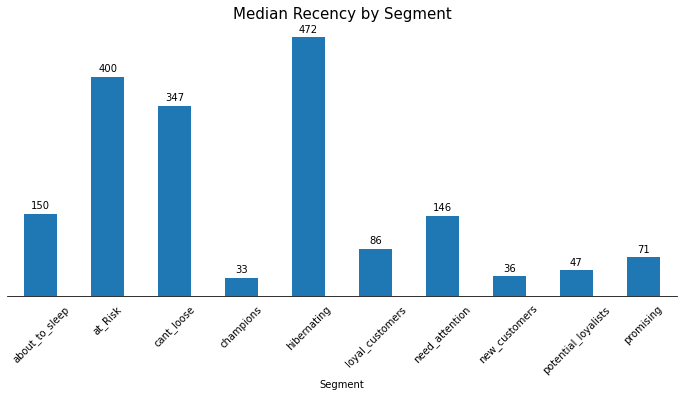

In [27]:
fig,ax = plt.subplots(figsize=(12,5))
rec_data = (rfm
            .groupby("Segment")
            .Recency
            .median()
            .head(10)
            )
(rec_data.plot.bar(ax=ax,rot=45))

ax.set_title("Median Recency by Segment",fontsize=15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.get_yaxis().set_visible(False)
ax.tick_params(bottom=False)
for pos, value in enumerate(rec_data):
    ax.text(pos, value+10, f"{value}",ha="center")



### Frequency by Segment Plot

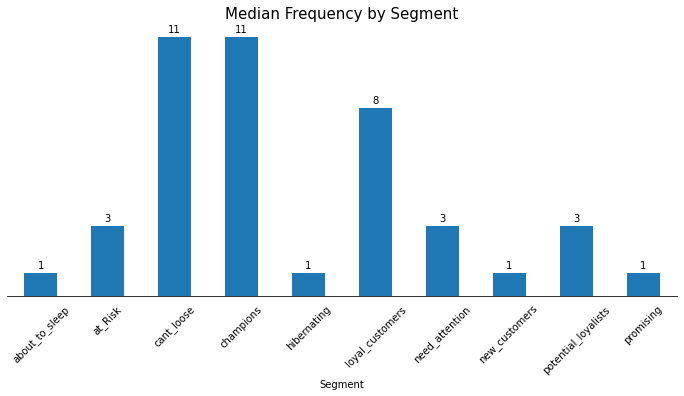

In [28]:
fig,ax = plt.subplots(figsize=(12,5))
freq_data = (rfm
            .groupby("Segment")
            .Frequency
            .median()
            .head(10)
            )
(freq_data.plot.bar(ax=ax,rot=45))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

ax.set_title("Median Frequency by Segment",fontsize=15)
ax.get_yaxis().set_visible(False)
ax.tick_params(bottom=False)
for pos, value in enumerate(freq_data):
    ax.text(pos, value+0.2, f"{value}",ha="center")



### Monetary by Segment Plot

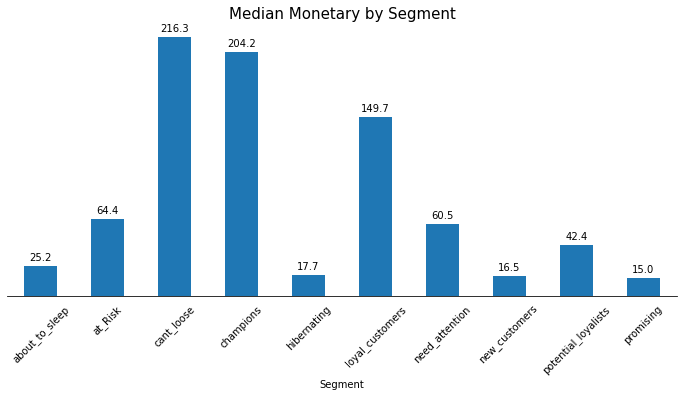

In [29]:
fig,ax = plt.subplots(figsize=(12,5))
mon_data = (rfm
            .groupby("Segment")
            .Monetary
            .median()
            .head(10)
            )
(mon_data.plot.bar(ax=ax,rot=45))

ax.set_title("Median Monetary by Segment",fontsize=15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.get_yaxis().set_visible(False)
ax.tick_params(bottom=False)
for pos, value in enumerate(round(mon_data,1)):
    ax.text(pos, value+5, f"{value}",ha="center")



## Clustring With The K-MEANS 

In [30]:
rfm_kmeans = rfm.loc[:,"Recency":"Monetary"]
rfm_kmeans.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,347,12,253.990
12347.0,61,7,160.835
12348.0,97,5,179.310
12349.0,40,4,95.025
12350.0,332,1,25.200


In [31]:
scaler = MinMaxScaler()
ndf = scaler.fit_transform(rfm_kmeans)

### Determining the K-Means Cluster Number - Inertia

In [32]:
max_cluster = 10

all_experiments = []

for n_cluster in range(1,max_cluster,1):
    kmeans = KMeans(n_clusters=n_cluster + 1, random_state=42)
    kmeans.fit(ndf)
    all_experiments.append(kmeans)

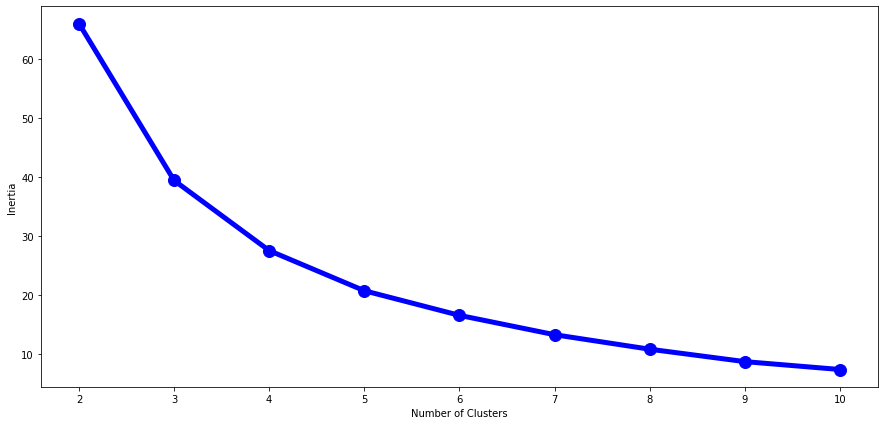

In [33]:
inertias = [experiment.inertia_ for experiment in all_experiments]
plt.figure(figsize=(15, 7))
plt.plot([2, 3, 4, 5, 6, 7, 8,9,10], inertias, 'bo-', linewidth=5, markersize=12)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

### Silhouette Score

* The value of the silhouette coefﬁcient is between [-1, 1].
* A score of 1 denotes the best meaning that the data point i is very compact within the cluster to which it belongs and far away from the other clusters.
* The worst value is -1. Values near 0 denote overlapping clusters.

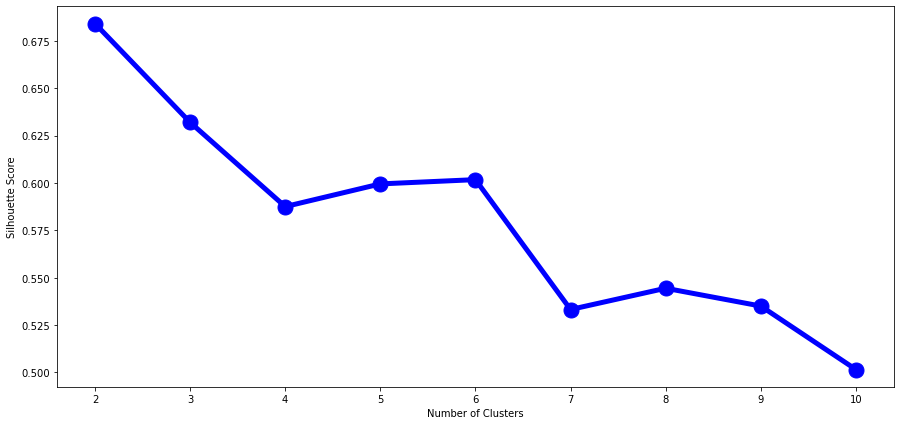

In [34]:
from sklearn.metrics import silhouette_score,silhouette_samples
silhouette_scores = [silhouette_score(ndf, experiment.labels_) for experiment in all_experiments]
plt.figure(figsize=(15, 7))
plt.plot([2, 3, 4, 5, 6, 7, 8,9,10], silhouette_scores, 'bo-', linewidth=5, markersize=15)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()


In [35]:
k_means = KMeans(n_clusters=6).fit(ndf)
clusters = k_means.labels_
c_ndf=rfm[["Recency","Frequency","Monetary"]]

c_ndf["cluster_no"] = clusters
c_ndf["cluster_no"] = c_ndf["cluster_no"] + 1
c_ndf.head()

<ipython-input-35-2c4672a08415>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_ndf["cluster_no"] = clusters
<ipython-input-35-2c4672a08415>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_ndf["cluster_no"] = c_ndf["cluster_no"] + 1


,Recency,Frequency,Monetary,cluster_no
Customer ID,,,,
12346.0,347,12,253.990,2
12347.0,61,7,160.835,1
12348.0,97,5,179.310,1
12349.0,40,4,95.025,1
12350.0,332,1,25.200,2


In [36]:
fig = px.scatter_3d(c_ndf, x=c_ndf["Recency"], y=c_ndf["Frequency"], z=c_ndf["Monetary"], color=c_ndf["cluster_no"])
fig.show()